Based on the results from the "Exploring Infection Dynamics" notebook this notebook collects state information on non-infected farms 20 days into the outbreak, and the status of the non-infected farms is collected 40 days into the outbreak. The goal of this notebook is to construct the best model that describes the relationship between various covariates and whether or not a farm becomes infected 20 days after state information is collected. It is important to note that the dataset is constructed by performing 1000 simulations and stacking the results of each run. Model selection is performed via AIC (recall that lower AIC is better).

In [1]:
import numpy as np
from random import randint
Size = 20
N = 75 
np.random.seed(53080)
x = Size*np.random.rand(N)
np.random.seed(23003)
y = Size*np.random.rand(N)  
#np.random.seed(10)
#Cows = np.array([randint(25,250) for p in range(N)])
Cows = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
#np.random.seed(11)
#Sheep = np.array([randint(25,250) for p in range(N)])
Sheep = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])


It is important to note that the location of the farms will not change from simulation to simulation, however the index of the infected farm and the size of the farm will change from simulation to simulation.

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


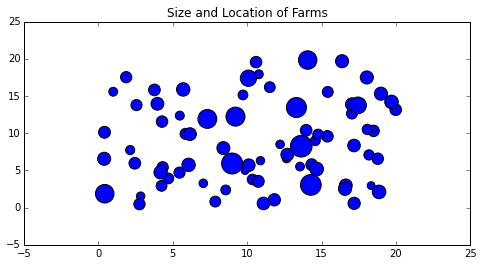

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.scatter(x,y,s=(Cows+Sheep))
plt.title("Size and Location of Farms")

There are a couple of important changes to the below function:

1) The first status is status = 6 not status = 1, this allows us to define an index infected farm as opposed to an index exposed farm

2) The other change is that there is an "end2" parameter which defines when Status information is collected

In [220]:
def Outbreaks(Size,N,Y0,farms,end,end2,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    
    Status = np.array([0]*N)    #Initial Status of each farm
    init_ind = np.random.randint(0,N)
    for i in range(Y0):
        Status[init_ind] = 6 #one farm is initially infected 

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
    def WhichGrid(x,y,XRange,YRange,XNum,YNum):
        #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
        #Returns a number from 1 to griddim^2
        return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    i = np.argsort(grid) #get indexed values after sort
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    index_inf = np.where(Status==6)[0].astype(int)
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()+1) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max()+1)
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))
    def Kernel(dist_squared):
        dist_squared = np.asarray(dist_squared)
        is_scalar = False if dist_squared.ndim > 0 else True
        dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
        K = 1 / (pi * (1 + dist_squared**2))
        K[(dist_squared < 0.0138)] = 0.3093
        K[(dist_squared > 60*60)] = 0
        return(K if not is_scalar else K[0])

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))+1):
       for j in range(1,int(max(grid))+1):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
        Event = 0*Status
        INF = np.where(Status>5)[0]
        NI = INF.size # Note reported farms still infectious
        IGrids = grid[INF]-1
        
        for ii in range(NI):
            INFi = INF[ii]
            trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
            maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
            # Elementwise multiplication
            rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
            MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
            rng = np.random.rand(len(MaxProb))
            m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
            for n in range(len(m)):
                s = 1
                M = m[n]
                PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
                if (PAB == 1):
                    # Calculate the infection probability for each farm in the susceptible grid
                    leng = last_in_grid[M]-first_in_grid[M]+1
                    R = np.random.rand(leng)
                    for j in range(leng):
                        ind1 = first_in_grid[M]+j-1
                        Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                        if ((R[j] < Q) & (Status[ind1] == 0)):
                            Event[ind1] = 1
                else:
                    R = np.random.rand(Num[M])
                    # Loop through all susceptible farms in the grids where an infection event occurred.  
                    for j in range(Num[M]):
                        P = 1 - s*(1 - PAB)**(Num[M] - j)
                        if (R[j] < (PAB / P)):
                            s = 0
                            ind1=first_in_grid[M]+j-1
                            Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1]**2+(y[INFi]-y[ind1])**2)))
                            if ((R[j]< Q/P) & (Status[ind1] == 0)):
                                Event[ind1] = 1
        # Evolve the infection process of those farms which have been exposed and already infectious ones.  
        Status[Status > 0] += 1
        Status = Status + Event
        #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
        #for i in range(len(m)):
        #    Status[m[i]]=-1;
        return {'Status':Status,'NI':NI}
    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<end, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
       
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if np.logical_or((E[-4]+I[-4]==0),I == N):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full
   
    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (no_this[:,2]>5).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[index_inf][0],coords[index_inf][1]))
    dist = []
    for j in range(0,N):
        b = np.array((coords[j][0],coords[j][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep,x,y]
    
    from scipy import spatial
    #Extract the infected farms
    inf_farms = to_return[to_return[:,1]==1]
    coords = list(zip(x,y))
    #Create list of coordinates infected farms
    inf_farm_coords = list(zip(inf_farms[:,5],inf_farms[:,6]))
    list_of_inf_coords = [list(elem) for elem in inf_farm_coords]
    #Create list of coordinates of all farms
    list_of_coords = [list(elem) for elem in coords]
    #Calculate Euclidean distance from each farm to all infected farms- each row in matrix represents
        #distance of one farm to each infected farm
    dist_to_inf = spatial.distance_matrix(list_of_coords,list_of_inf_coords)
    #Find distance to closest infected farm
    def minval(array):
        #return(np.min(array[np.nonzero(array)]))
        return(np.min(array))
    closest_infected = np.apply_along_axis(minval,1,dist_to_inf)
    average_infected = np.apply_along_axis(np.mean,1,dist_to_inf)
    to_return = np.c_[to_return,closest_infected,average_infected]
    
    #Create list of number of Cows and number of sheep for infected farms
    inf_farm_cows = list(inf_farms[:,3])
    inf_farm_sheep = list(inf_farms[:,4])
    #Create a function that extracts farm size based on closest infected farm
    def where_minval(array):
        #return(np.argmin(array[np.nonzero(array)]))
        return(np.argmin(array))
    closest_infected_size_ind = np.apply_along_axis(where_minval,1,dist_to_inf)
    closest_infected_cows = [inf_farm_cows[i] for i in closest_infected_size_ind]
    closest_infected_sheep = [inf_farm_sheep[i] for i in closest_infected_size_ind]

    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep,x,y,,disttoclosestinf,avgdisttoinf,#cowsinclosestiffarm,#sheepinclosestinffarm
    to_return = np.c_[to_return,closest_infected_cows,closest_infected_sheep]
    
    #Now run the outbreak for the additional end - end2 steps
    while(np.logical_and(t[-1]<end2, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']

        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
    #Return only the data where a farm was not infected by the "end" day
    not_inf = to_return[to_return[:,1]==0]
    #append the status of these farms after the additional end2 - end days
    newstatus = [Status[i] for i in not_inf[:,0]-1]
    newstatus_ind = np.array([i>5 for i in newstatus]).astype(int)
    final = np.c_[not_inf,newstatus_ind]
    return(final)
    
test = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,end2=40,x=x,y=y,Cows=Cows,Sheep=Sheep)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:88: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:97: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:162: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:215: DeprecationWarning: using a non-integer number instead of an integer will result in

In [221]:
test[:,11]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
        0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,
        0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.])

In [171]:
import numpy as np
from random import randint
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,end2=40,x=x,y=y,Cows=Cows,Sheep=Sheep)
Outbreak = np.c_[np.array([1]*Outbreak.shape[0]),Outbreak]
Num_outbreaks = 1000
for i in range(Num_outbreaks):
    #Cows = np.array([randint(25,250) for p in range(N)])
    Cows = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
    #Sheep = np.array([randint(25,250) for p in range(N)])
    Sheep = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
    add = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=20,end2=40,x=x,y=y,Cows=Cows,Sheep=Sheep)
    add = np.c_[np.array([i+2]*add.shape[0]),add]
    new_Outbreak = np.r_[Outbreak,add]
    Outbreak = new_Outbreak 
    print(i,np.sum(add[:,12]==1))



/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:55: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:88: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:97: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:162: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:215: DeprecationWarning: using a non-integer number instead of an integer will result in

0 0
1 8
2 11
3 7
4 1
5 0
6 1
7 9
8 28
9 1
10 17
11 7
12 3
13 7
14 0
15 6
16 0
17 12
18 2
19 12
20 9
21 15
22 0
23 2
24 1
25 16
26 9
27 5
28 0
29 3
30 10
31 0
32 14
33 10
34 7
35 10
36 1
37 2
38 0
39 8
40 4
41 1
42 0
43 3
44 5
45 13
46 2
47 11
48 11
49 17
50 12
51 1
52 1
53 5
54 2
55 6
56 13
57 9
58 1
59 14
60 15
61 18
62 15
63 9
64 13
65 2
66 10
67 1
68 16
69 11
70 20
71 1
72 1
73 2
74 7
75 0
76 11
77 20
78 22
79 7
80 3
81 2
82 6
83 17
84 4
85 0
86 9
87 9
88 5
89 3
90 9
91 1
92 0
93 9
94 8
95 2
96 20
97 11
98 5
99 6
100 14
101 7
102 2
103 11
104 0
105 0
106 1
107 6
108 8
109 14
110 4
111 24
112 12
113 0
114 20
115 9
116 13
117 11
118 24
119 6
120 19
121 10
122 1
123 10
124 5
125 8
126 9
127 15
128 1
129 15
130 5
131 0
132 1
133 2
134 0
135 3
136 5
137 1
138 8
139 17
140 7
141 3
142 10
143 8
144 6
145 0
146 14
147 15
148 1
149 7
150 0
151 9
152 11
153 3
154 1
155 0
156 13
157 8
158 19
159 11
160 13
161 6
162 2
163 18
164 18
165 15
166 8
167 14
168 4
169 0
170 14
171 19
172 0
173 0
174 8

In [172]:
Outbreak.shape

(71133, 13)

In [173]:
import pandas as pd
df = pd.DataFrame(Outbreak)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep','x-coord','y-coord','DistToNearestInfected','AvgDistToInfected','CowsNearestInfected','SheepNearestInfected','Status2']
long_random_everything_andind_anddist2 = df
long_random_everything_andind_anddist2

,run,farmID,Status,DistToIndex,NumCows,NumSheep,x-coord,y-coord,DistToNearestInfected,AvgDistToInfected,CowsNearestInfected,SheepNearestInfected,Status2
0,1,1,0,13.108497,38,35,0.428463,1.864803,9.473992,14.230768,59,55,0
1,1,2,0,12.258295,25,49,0.391203,6.562081,8.619805,13.138067,59,55,0
2,1,3,0,12.730272,26,33,0.414427,10.122575,9.544863,13.353206,59,55,0
3,1,4,0,14.703487,45,45,0.996829,15.573354,12.526407,14.890332,59,55,0
4,1,5,0,15.346066,48,37,1.869069,17.528015,13.611202,15.361761,59,55,0
5,1,6,0,11.640965,34,49,2.762186,0.461724,8.283747,12.861667,59,55,0
6,1,7,0,11.042176,30,35,2.842180,1.531988,7.555035,12.233097,59,55,0
7,1,8,0,10.220101,44,48,2.449791,5.959629,6.537846,11.170254,59,55,0
8,1,9,0,10.571078,27,41,2.138491,7.732310,7.083087,11.384365,59,55,0
9,1,10,0,11.373379,40,40,3.969138,13.955119,9.467895,11.573826,59,55,0


In [222]:
long_random_everything_andind_anddist2.to_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/long_random_everything_andind_anddist2.pkl') 

In [ ]:
import pandas as pd
long_random_everything_andind_anddist2 = pd.read_pickle('/Users/sandyalakkur/Documents/GradSchool/Research/AMFMDIdeas/long_random_everything_andind_anddist2.pkl')

Model with Only Distance to Index
---------------------------------

Likelihood: $y_i \sim Bern(p_i)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $p_i$ = $logit^{-1}$($\beta_0$ + $\beta_1$(Distance to Index) + $\beta_2$(#CowsNearestInfectedFarm) + $\beta_3$(#SheepNearestInfectedFarm))

Priors: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\beta_{0,1,2,3} \sim N(0,1000)$
    



In [174]:
dist_diff = (long_random_everything_andind_anddist2['DistToIndex'] - long_random_everything_andind_anddist2['DistToIndex'].mean())/5
closest_cow_diff = (long_random_everything_andind_anddist2['CowsNearestInfected'] - long_random_everything_andind_anddist2['CowsNearestInfected'].mean())/20
closest_sheep_diff = (long_random_everything_andind_anddist2['SheepNearestInfected'] - long_random_everything_andind_anddist2['SheepNearestInfected'].mean())/20
status = long_random_everything_andind_anddist2['Status2']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = 0)
    
    size_coef = Normal ('size_coef', mu=0., tau= 0.001, value=[0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, size_coef= size_coef: 
                  invlogit(intercept + first_coef*dist_diff + size_coef[0]*closest_cow_diff + 
                           size_coef[1]*closest_sheep_diff))
    
    y = Bernoulli('y', p=prob, value=status, observed=True)
    
    return locals()

In [175]:
chains = 2
iterations = 10000
burn = 4000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 145.6 sec

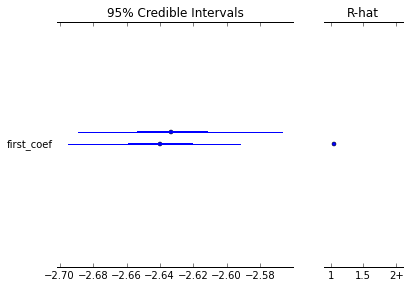

In [176]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.first_coef)

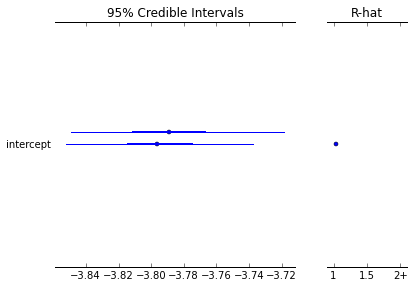

In [177]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.intercept)

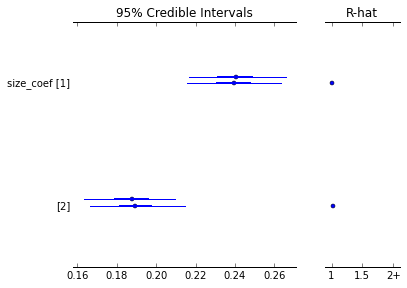

In [178]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.size_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


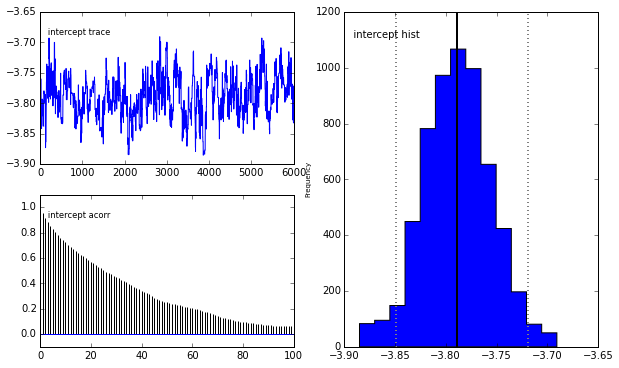

In [179]:
Matplot.plot(M_pooled.intercept)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


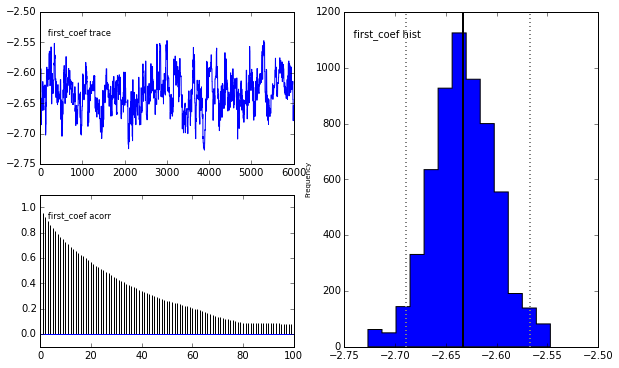

In [180]:
Matplot.plot(M_pooled.first_coef)

Plotting size_coef_0
Plotting size_coef_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


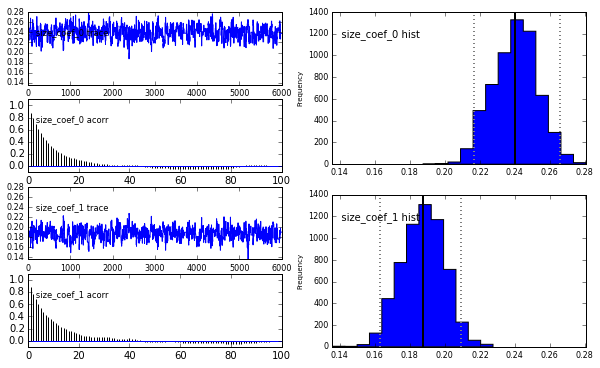

In [181]:
Matplot.plot(M_pooled.size_coef)

In [182]:
# #distance: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('first_coef')[:].mean()),np.exp(np.percentile(M_pooled.trace('first_coef')[:],2.5)),np.exp(np.percentile(M_pooled.trace('first_coef')[:],97.5)))

(0.071879978378140433, 0.067428214827203126, 0.07663779360725137)

In [183]:
# #of cows in nearest infected farm: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('size_coef')[:,0].mean()),np.exp(np.percentile(M_pooled.trace('size_coef')[:,0],2.5)),np.exp(np.percentile(M_pooled.trace('size_coef')[:,0],97.5)))

(1.2712965573057904, 1.2405472546841103, 1.3034745082580459)

In [184]:
# #of sheep in nearest infected farm: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('size_coef')[:,1].mean()),np.exp(np.percentile(M_pooled.trace('size_coef')[:,1],2.5)),np.exp(np.percentile(M_pooled.trace('size_coef')[:,1],97.5)))

(1.2062019247274087, 1.1778563025891309, 1.2350281457204793)

In [185]:
M = MAP(pooled_model())
M.fit()

In [186]:
M.AIC

31228.221759408152

Model with Only Distance to Nearest Infected
------------------------------------------

Likelihood: $y_i \sim Bern(p_i)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $p_i$ = $logit^{-1}$($\beta_0$ + $\beta_1$(Distance to Nearest Infected) + $\beta_2$(#CowsNearestInfectedFarm) + $\beta_3$(#SheepNearestInfectedFarm))

Priors: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\beta_{0,1,2,3} \sim N(0,1000)$
    




In [187]:
dist_diff = (long_random_everything_andind_anddist2['DistToNearestInfected'] - long_random_everything_andind_anddist2['DistToNearestInfected'].mean())/5
closest_cow_diff = (long_random_everything_andind_anddist2['CowsNearestInfected'] - long_random_everything_andind_anddist2['CowsNearestInfected'].mean())/20
closest_sheep_diff = (long_random_everything_andind_anddist2['SheepNearestInfected'] - long_random_everything_andind_anddist2['SheepNearestInfected'].mean())/20
status = long_random_everything_andind_anddist2['Status2']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = 0)
    
    size_coef = Normal ('size_coef', mu=0., tau= 0.001, value=[0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, size_coef= size_coef: 
                  invlogit(intercept + first_coef*dist_diff + size_coef[0]*closest_cow_diff + 
                           size_coef[1]*closest_sheep_diff))
    
    y = Bernoulli('y', p=prob, value=status, observed=True)
    
    return locals()

In [188]:
chains = 2
iterations = 10000
burn = 4000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 124.5 sec

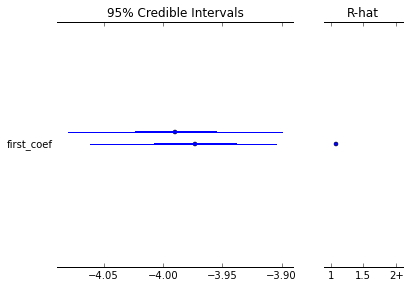

In [189]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.first_coef)

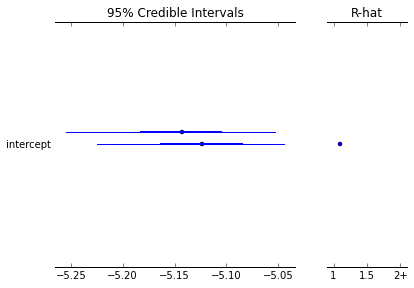

In [190]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.intercept)

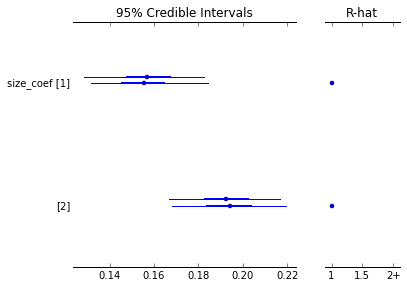

In [191]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.size_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


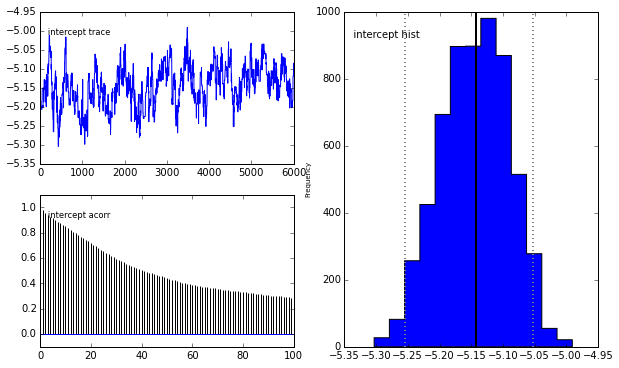

In [192]:
Matplot.plot(M_pooled.intercept)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


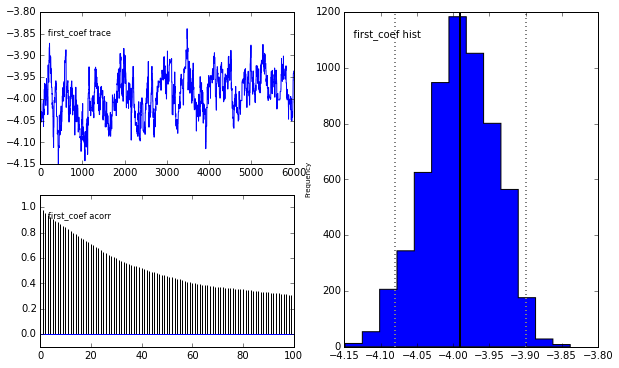

In [193]:
Matplot.plot(M_pooled.first_coef)

Plotting size_coef_0
Plotting size_coef_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


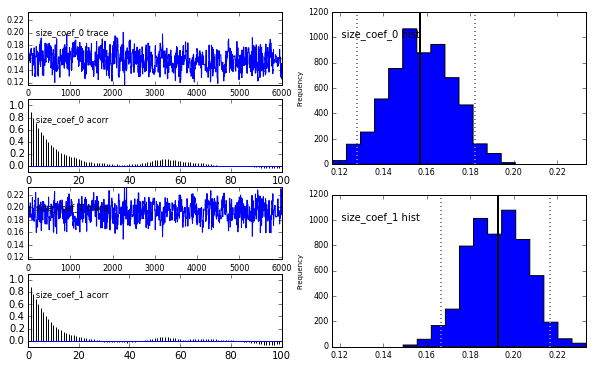

In [194]:
Matplot.plot(M_pooled.size_coef)

In [195]:
# #distance: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('first_coef')[:].mean()),np.exp(np.percentile(M_pooled.trace('first_coef')[:],2.5)),np.exp(np.percentile(M_pooled.trace('first_coef')[:],97.5)))

(0.018490016389219436, 0.016799068994519755, 0.020150662885541359)

In [196]:
# #of cows in nearest infected farm: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('size_coef')[:,0].mean()),np.exp(np.percentile(M_pooled.trace('size_coef')[:,0],2.5)),np.exp(np.percentile(M_pooled.trace('size_coef')[:,0],97.5)))

(1.1702841481868709, 1.1376796816916863, 1.2036411417229116)

In [197]:
# #of sheep in nearest infected farm: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('size_coef')[:,1].mean()),np.exp(np.percentile(M_pooled.trace('size_coef')[:,1],2.5)),np.exp(np.percentile(M_pooled.trace('size_coef')[:,1],97.5)))

(1.2122014022748404, 1.1815225478843678, 1.2423613653959349)

In [198]:
M = MAP(pooled_model())
M.fit()

In [199]:
M.AIC

25732.888436115918

Model with Only Average Distance to Infected
----------------------------------------------

Likelihood: $y_i \sim Bern(p_i)$

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $p_i$ = $logit^{-1}$($\beta_0$ + $\beta_1$(Average Distance to Infected) + $\beta_2$(#CowsNearestInfectedFarm) + $\beta_3$(#SheepNearestInfectedFarm))

Priors: 

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $\beta_{0,1,2,3} \sim N(0,1000)$
    



In [201]:
dist_diff = (long_random_everything_andind_anddist2['AvgDistToInfected'] - long_random_everything_andind_anddist2['AvgDistToInfected'].mean())/5
closest_cow_diff = (long_random_everything_andind_anddist2['CowsNearestInfected'] - long_random_everything_andind_anddist2['CowsNearestInfected'].mean())/20
closest_sheep_diff = (long_random_everything_andind_anddist2['SheepNearestInfected'] - long_random_everything_andind_anddist2['SheepNearestInfected'].mean())/20
status = long_random_everything_andind_anddist2['Status2']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = 0)
    
    size_coef = Normal ('size_coef', mu=0., tau= 0.001, value=[0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, size_coef= size_coef: 
                  invlogit(intercept + first_coef*dist_diff + size_coef[0]*closest_cow_diff + 
                           size_coef[1]*closest_sheep_diff))
    
    y = Bernoulli('y', p=prob, value=status, observed=True)
    
    return locals()

In [202]:
chains = 2
iterations = 10000
burn = 4000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 166.0 sec

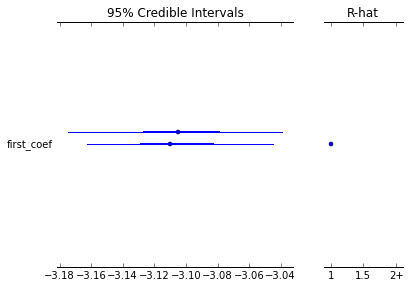

In [203]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.first_coef)

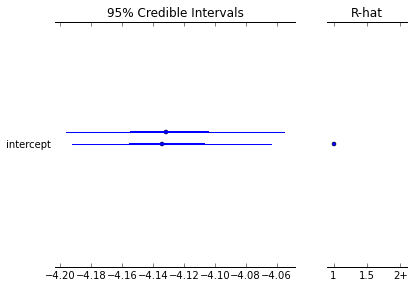

In [204]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.intercept)

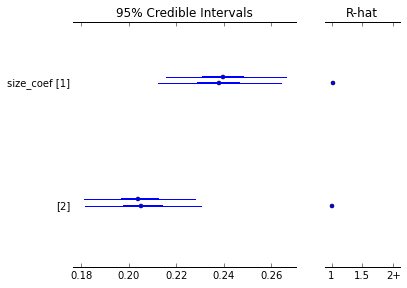

In [205]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.size_coef)

Plotting intercept


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


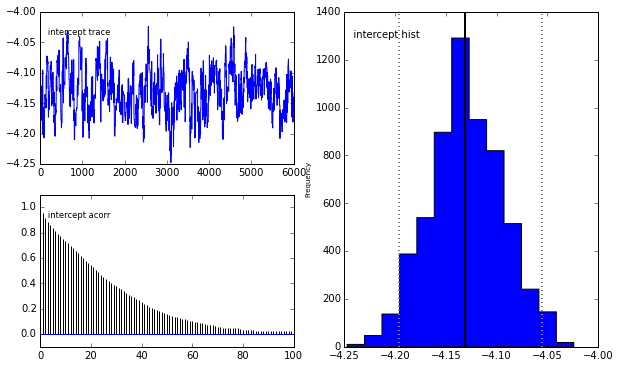

In [206]:
Matplot.plot(M_pooled.intercept)

Plotting first_coef


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


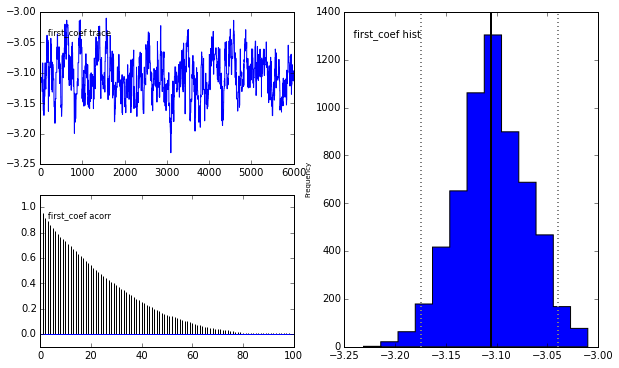

In [207]:
Matplot.plot(M_pooled.first_coef)

Plotting size_coef_0
Plotting size_coef_1


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


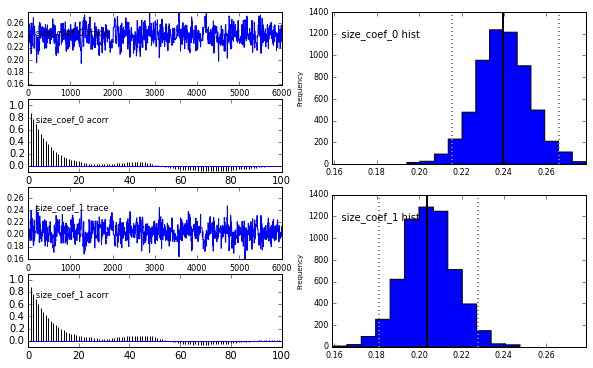

In [208]:
Matplot.plot(M_pooled.size_coef)

In [209]:
# #distance: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('first_coef')[:].mean()),np.exp(np.percentile(M_pooled.trace('first_coef')[:],2.5)),np.exp(np.percentile(M_pooled.trace('first_coef')[:],97.5)))

(0.044857276583669718, 0.041835338114075721, 0.047922728820432067)

In [210]:
# #of cows in nearest infected farm: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('size_coef')[:,0].mean()),np.exp(np.percentile(M_pooled.trace('size_coef')[:,0],2.5)),np.exp(np.percentile(M_pooled.trace('size_coef')[:,0],97.5)))

(1.2706485781124297, 1.2389619080591019, 1.3037009648313114)

In [211]:
# #of sheep in nearest infected farm: mean, 2.5%, 97.5%
(np.exp(M_pooled.trace('size_coef')[:,1].mean()),np.exp(np.percentile(M_pooled.trace('size_coef')[:,1],2.5)),np.exp(np.percentile(M_pooled.trace('size_coef')[:,1],97.5)))

(1.2268547155804146, 1.198363431919157, 1.2560930326715902)

In [212]:
M = MAP(pooled_model())
M.fit()

In [213]:
M.AIC

29650.493654068327